In [1]:
#Copyright 2019, Seokjun Bu, Softcomputing LAB all rights reserved.
%matplotlib inline
import glob
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from keras import backend as K
from keras.models import Model, load_model
from keras.utils import np_utils, multi_gpu_model
from keras.callbacks import EarlyStopping
from keras.layers import Input, Lambda, concatenate, TimeDistributed, CuDNNLSTM, BatchNormalization, LSTM
from keras.layers.core import Dense, Dropout, Flatten, Reshape
from keras.layers.convolutional import Convolution1D, MaxPooling1D
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, normalize

Using TensorFlow backend.


In [2]:
# Handcrafted Function Definition
def plot_history(model_input, mode='loss', title='Entropy'):
    history = model_input.history
    plt.plot(history.history[mode])
    plt.plot(history.history['val_'+mode])
    plt.title(title)
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()
def minmax_normalize_columnwise(input_np):
    output_np = np.zeros((input_np.shape[0], input_np.shape[1]))
    for c in range(input_np.shape[1]):
        col_min, col_max = np.min(input_np[:, c]), np.max(input_np[:, c])
        output_np[:, c] = input_np[:, c]
        output_np[:, c] -= col_min
        output_np[:, c] /= (col_max-col_min)
    return output_np
def sliding_window_np(input_np, window_size, stride):
    n_window = input_np.shape[0]-window_size+1
    X_output, Y_output = np.zeros((input_np.shape[0], window_size, input_np.shape[1])), np.zeros((input_np.shape[0], ))
    for r in range(n_window-1):
        X_output[r] = input_np[r:r+window_size]
        Y_output[r] = input_np[r+window_size, -1]
    return X_output, Y_output

In [3]:
# Column Info.
df = pd.read_pickle('../../dataset_tmp/fastcampus_school/2/df.pkl')
columns = df.columns.values[1:]
print(columns)

['timestamp' 'hour' 'weekday' 'Temp' 'Precipitation' 'Snowfall'
 'Wind_speed' 'Wind_dir' 'Humidity' 'Air_pressure' 'NO2' 'O3' 'CO' 'SO2'
 'PM10' 'PM25' 'bike_feed' 'bike_count']


In [4]:
# Load Dataset
train, validation, test = pd.read_pickle('../../dataset_tmp/fastcampus_school/2/df_train_timeseries.pkl').values[:, 1:], pd.read_pickle('../../dataset_tmp/fastcampus_school/2/df_val_timeseries.pkl').values[:, 1:], pd.read_pickle('../../dataset_tmp/fastcampus_school/2/df_test_timeseries.pkl').values[:, 1:]
print(train.shape, validation.shape, test.shape)

(10461, 19) (4184, 19) (6277, 19)


[[ 0.000e+00  0.000e+00  2.000e-01 ...  0.000e+00  0.000e+00  7.900e+01]
 [ 1.000e+00  0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00  8.300e+01]
 [ 2.000e+00  0.000e+00 -3.000e-01 ...  0.000e+00  0.000e+00  6.100e+01]
 ...
 [ 2.200e+01  1.000e+00  1.870e+01 ...  0.000e+00  0.000e+00  3.384e+03]
 [ 2.300e+01  1.000e+00  1.850e+01 ...  0.000e+00  0.000e+00  2.500e+03]
 [ 0.000e+00  1.000e+00  1.750e+01 ...  0.000e+00  0.000e+00  2.264e+03]]


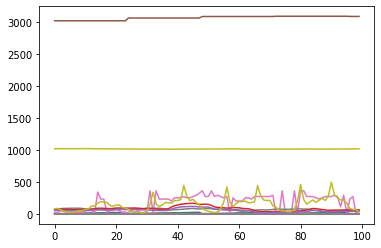

[[0.         0.         0.31468531 ... 0.         0.         0.00772354]
 [0.04347826 0.         0.31118881 ... 0.         0.         0.00811962]
 [0.08695652 0.         0.30594406 ... 0.         0.         0.00594118]
 ...
 [0.95652174 1.         0.63811189 ... 0.         0.         0.33498366]
 [1.         1.         0.63461538 ... 0.         0.         0.24745024]
 [0.         1.         0.61713287 ... 0.         0.         0.22408159]]


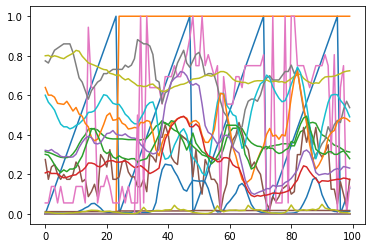

In [5]:
# Normalize Dataset
dataset = np.concatenate((train, validation, test), axis=0)
dataset_norm = minmax_normalize_columnwise(dataset)
lim = 100
print(dataset)
plt.plot(dataset[:lim])
plt.show()
print(dataset_norm)
plt.plot(dataset_norm[:lim])
plt.show()

In [6]:
# Preprocessing: Sliding-window
window_size = 30
n_window = dataset.shape[0]-window_size+1
X, Y = np.zeros((dataset.shape[0], window_size, dataset.shape[1])), np.zeros((dataset.shape[0],))
for r in range(n_window-1):
    X[r], Y[r] = dataset_norm[r:r+window_size], dataset_norm[r+window_size, -1]
print(X.shape, Y.shape)

(20922, 30, 19) (20922,)


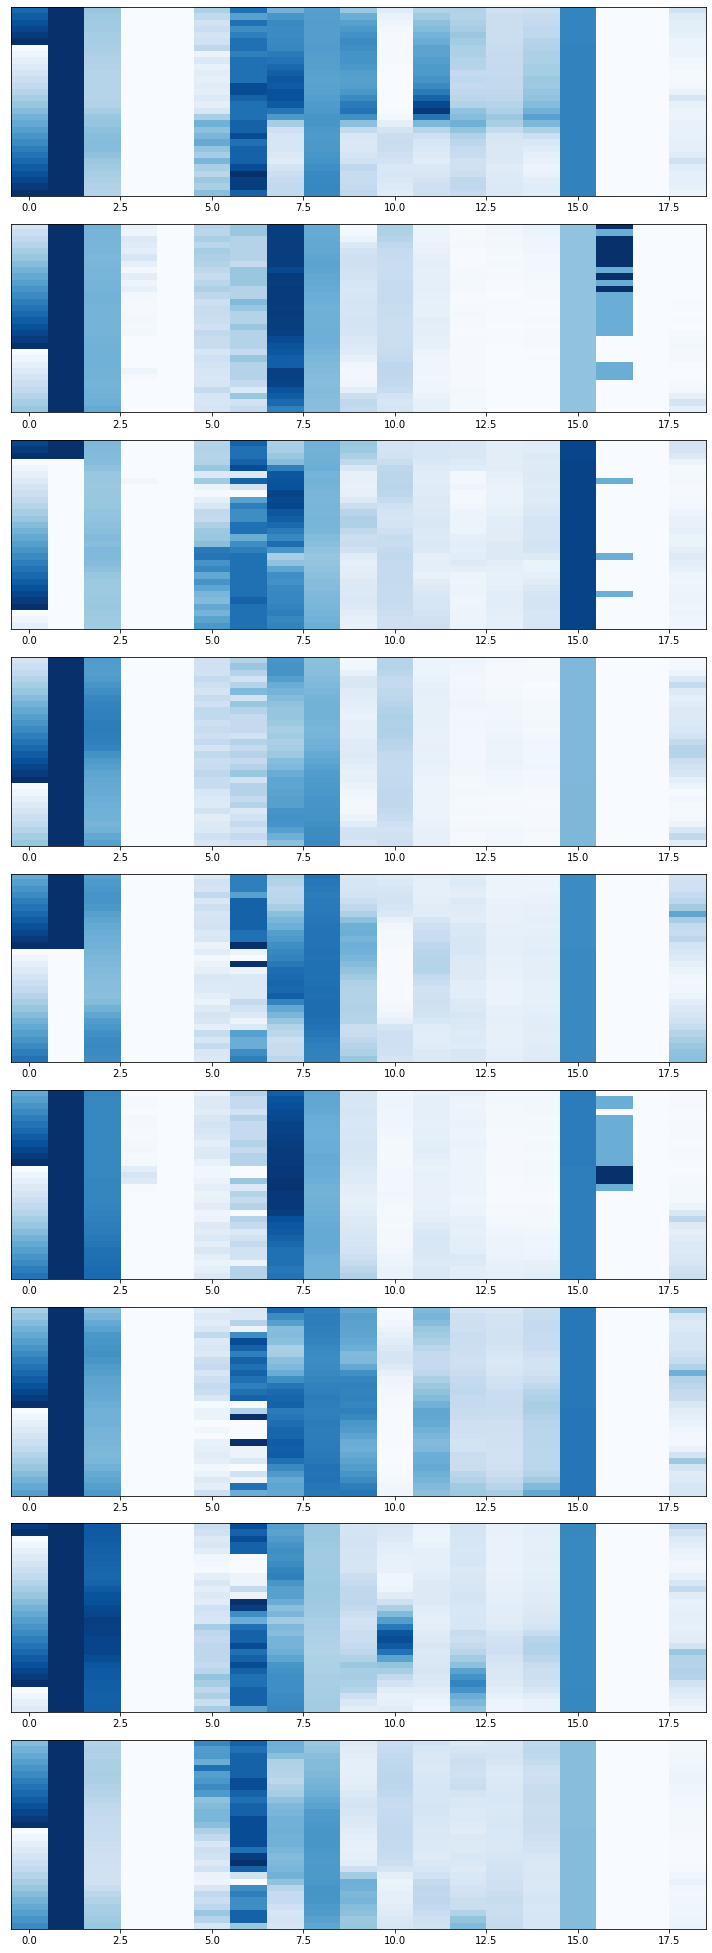

In [7]:
# Visualize Windows, Target Var.
n_vis = 10
rand_idx = np.random.randint(0, X.shape[0], n_vis)
X_sample, Y_sample = X[rand_idx], Y[rand_idx]
fig = plt.figure(figsize=(10, 30))
for nv in range(1, n_vis):
    subplot = fig.add_subplot(n_vis, 1, nv)
    subplot.imshow(X_sample[nv], cmap=plt.cm.Blues, aspect='auto')
    subplot.set_yticks([])
plt.tight_layout()
plt.show()

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, shuffle=False)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(14645, 30, 19) (14645,)
(6277, 30, 19) (6277,)


Window Size: 3


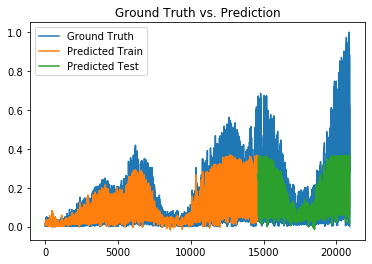

Train loss: 0.0016, Test loss: 0.0056
Window Size: 5


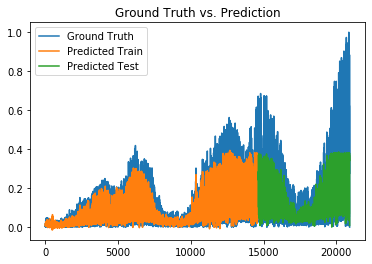

Train loss: 0.0016, Test loss: 0.0055
Window Size: 7


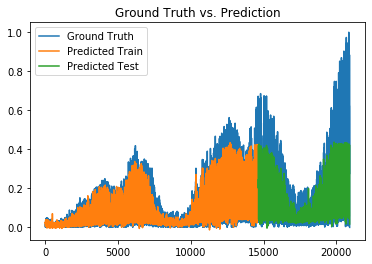

Train loss: 0.0015, Test loss: 0.0050
Window Size: 10


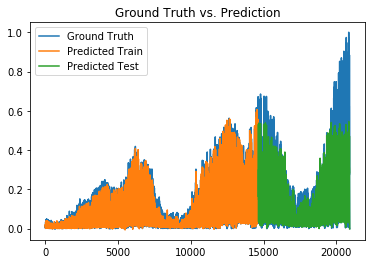

Train loss: 0.0008, Test loss: 0.0030
Window Size: 15


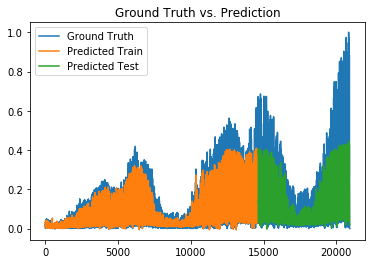

Train loss: 0.0012, Test loss: 0.0046
Window Size: 20


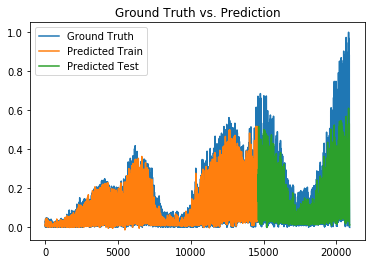

Train loss: 0.0009, Test loss: 0.0036
Window Size: 25


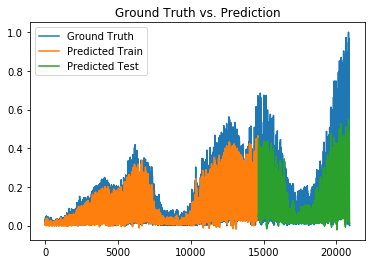

Train loss: 0.0011, Test loss: 0.0042
Window Size: 30


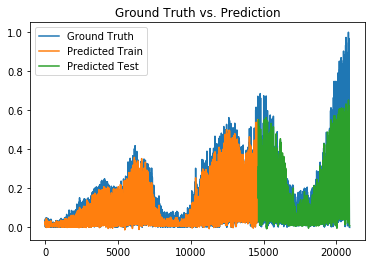

Train loss: 0.0008, Test loss: 0.0028
Window Size: 35


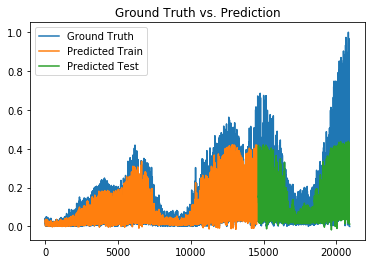

Train loss: 0.0011, Test loss: 0.0045
Window Size: 40


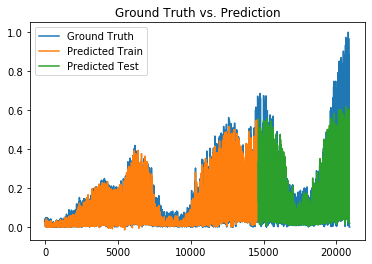

Train loss: 0.0008, Test loss: 0.0027
Window Size: 45


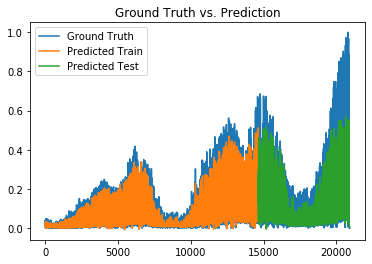

Train loss: 0.0009, Test loss: 0.0033
Window Size: 50


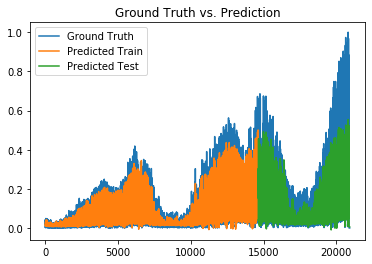

Train loss: 0.0009, Test loss: 0.0034
Window Size: 55


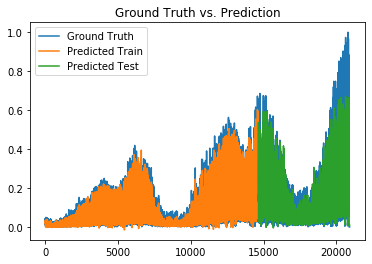

Train loss: 0.0008, Test loss: 0.0028
Window Size: 60


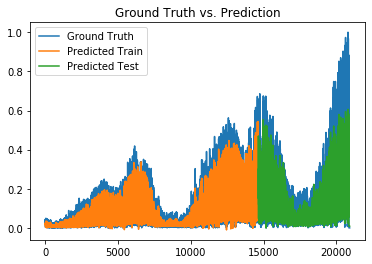

Train loss: 0.0009, Test loss: 0.0032


In [25]:
window_params = [3, 5, 7, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]
for wp in window_params:
    # Preprocessing: Sliding-window
    print("Window Size: %d" %(wp))
    window_size = wp
    n_window = dataset.shape[0]-window_size+1
    X, Y = np.zeros((dataset.shape[0], window_size, dataset.shape[1])), np.zeros((dataset.shape[0],))
    for r in range(n_window-1):
        X[r], Y[r] = dataset_norm[r:r+window_size], dataset_norm[r+window_size, -1]
#     print(X.shape, Y.shape)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, shuffle=False)
#     print(X_train.shape, Y_train.shape)
#     print(X_test.shape, Y_test.shape)
    # Build Deeper Model
    c_input = Input(shape=(X.shape[1],X.shape[2]))
    H = Reshape((X.shape[1], X.shape[2], 1))(c_input)
    H = TimeDistributed(Convolution1D(filters=32, kernel_size=(2), padding='same', activation='tanh'))(H)
    H = TimeDistributed(MaxPooling1D(2))(H)
    H = TimeDistributed(Convolution1D(filters=32, kernel_size=(2), padding='same', activation='tanh'))(H)
    H = TimeDistributed(MaxPooling1D(2))(H)
    H = TimeDistributed(Flatten())(H)
    H = Dropout(0.75)(H)
    H = CuDNNLSTM(128, return_sequences=True)(H)
    H = CuDNNLSTM(128, return_sequences=False)(H)
    H = Dropout(0.75)(H)
    H = Dense(128, activation='tanh')(H)
    H = Dense(64, activation='tanh')(H)
    c_output = Dense(1, activation='tanh')(H)
    model_cnn_lstm = Model(c_input, c_output)
    model_cnn_lstm = multi_gpu_model(model_cnn_lstm, gpus=4)
    model_cnn_lstm.compile(loss='mse', optimizer='adam', metrics=['binary_crossentropy'])
    # Train Model
    es = EarlyStopping(monitor='val_loss', mode='auto', patience=20)
    train_history = model_cnn_lstm.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=2000, batch_size=2000, callbacks=[es], verbose=0, shuffle=True)
    # Validation
    # Curve
#     plot_history(model_cnn_lstm, mode='loss', title='Mean Squared Error')
#     plot_history(model_cnn_lstm, mode='binary_crossentropy', title='Binary Crossentropy')
    # Prediction
    Y_train_hat = model_cnn_lstm.predict(X_train)
    Y_test_hat = model_cnn_lstm.predict(X_test)
    plt.plot(range(Y_train_hat.shape[0]+Y_test_hat.shape[0]), np.concatenate((Y_train, Y_test)), label='Ground Truth') # Ground Truth
    plt.plot(range(Y_train_hat.shape[0]), Y_train_hat, label='Predicted Train') # Train Period Prediction
    plt.plot(range(Y_train_hat.shape[0], Y_train_hat.shape[0]+Y_test_hat.shape[0]), Y_test_hat, label='Predicted Test') # Test Period Prediction
    plt.legend(loc='upper left')
    plt.title('Ground Truth vs. Prediction')
    plt.show()
    print("Train loss: %.4f, Test loss: %.4f" %(train_history.history['loss'][-1], train_history.history['val_loss'][-1]))